# Transformer Architecture

## NN for language translation (Portugese to English)

This code is taken from the tutorial `https://www.tensorflow.org/tutorials/text/transformer`. Will be modified to extract the weights from training.


In [1]:
pip install -q tensorflow_datasets

In [2]:
pip install -q tensorflow-text

     |████████████████████████████████| 3.4MB 5.5MB/s 


In [3]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_text as text

import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
sns.set(font_scale=1.5)

from google.colab import drive
drive.mount('drive')

Mounted at drive


In [4]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete9CUS2R/ted_hrlr_translate-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete9CUS2R/ted_hrlr_translate-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete9CUS2R/ted_hrlr_translate-test.tfrecord


Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [5]:
examples

{'test': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.string)>,
 'train': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.string)>,
 'validation': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.string)>}

In [6]:
train_examples, val_examples = examples['train'], examples['validation']

In [7]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))

  print()

  for en in en_examples.numpy():
    print(en.decode('utf-8'))

e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [8]:
metadata

tfds.core.DatasetInfo(
    name='ted_hrlr_translate',
    version=1.0.0,
    description='Data sets derived from TED talk transcripts for comparing similar language pairs
where one is high resource and the other is low resource.',
    homepage='https://github.com/neulab/word-embeddings-for-nmt',
    features=Translation({
        'en': Text(shape=(), dtype=tf.string),
        'pt': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=54781,
    splits={
        'test': 1803,
        'train': 51785,
        'validation': 1193,
    },
    supervised_keys=('pt', 'en'),
    citation="""@inproceedings{Ye2018WordEmbeddings,
      author  = {Ye, Qi and Devendra, Sachan and Matthieu, Felix and Sarguna, Padmanabhan and Graham, Neubig},
      title   = {When and Why are pre-trained word embeddings useful for Neural Machine Translation},
      booktitle = {HLT-NAACL},
      year    = {2018},
      }""",
    redistribution_info=,
)

In [9]:
model_name = "ted_hrlr_translate_pt_en_converter"
tf.keras.utils.get_file(
    f"{model_name}.zip",
    f"https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip",
    cache_dir='.', cache_subdir='', extract=True
)

188416/184801 [==============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

## Input embedding (Tokenization)

Perform input embedding using a trained BERTtokenization model. Tokenization is the process of taking a sentence/paragraph, and splitting the sentence/paragraph into smaller units such as words, punctuation, regularity of words etc as a string and putting them into a list. The smaller units arre called tokens. This identifies the words that are in the sentence/paragraph, so that we can start to learn the meaning of the words in the sentence. 

We do this as heuristically, we can analyse the meaning of the sentence from analysing the words in the sentence. 

Note that start and end tokens are also generated from the BERTtokenization model. 

In [10]:
tokenizers = tf.saved_model.load(model_name)

There are 2 text tokenizers, 1 for English and 1 for Portugese. These tokenizers have been trained on English and Portugese texts respectively via the BERTtokenizer. The BERTtokenizer tokenizes the English/Portugese words in the most "efficient way". Both tokenizers have the same set of functions to tokenize the words.

In [11]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [12]:
[item for item in dir(tokenizers.pt) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [13]:
for en in en_examples.numpy():
  print(en.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


Tokenize the above English text into token IDs using the previously trained tokenized model, to get the output below. Then we will detokenize the text back to English. The token IDs are the list of numbers. This is a 1-1 mapping.

In [14]:
encoded = tokenizers.en.tokenize(en_examples)

for row in encoded.to_list():
  print(row)

[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


In [15]:
round_trip = tokenizers.en.detokenize(encoded)
for line in round_trip.numpy():
  print(line.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


A lower level method called lookup converts from token IDs (numbers) to token texts.

In [16]:
tokens = tokenizers.en.lookup(encoded)
tokens

<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability', b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage', b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip', b'##ity', b'.', b'[END]'], [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?', b'[END]'], [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for', b'curiosity', b'.', b'[END]']]>

Function for input embedding by tokenizing the English and Portugese texts.

In [17]:
def tokenize_pairs(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    # Convert from ragged to dense, padding with zeros.
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()
    return pt, en

Input the data in batches, by creating a pipeline for it.

In [18]:
BUFFER_SIZE = 20000
BATCH_SIZE = 32

In [19]:
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE))

train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

## Positional Encoding

We will use the same positional encoding as described by "Attention is all you need" paper.

In [20]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [21]:
# returns an array of cyclical numbers which represent the relative importance of the position of the words. The content of the
# words is independent of its position. 

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 2048, 512)


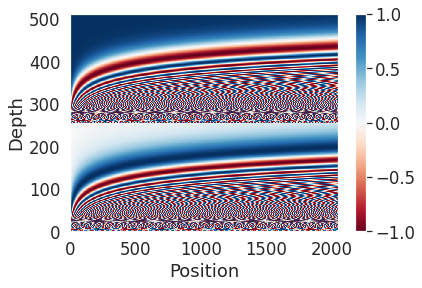

In [22]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2,1,0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

Y axis is the dimension of the vector (512), while X axis is the position of the words in the paragraph sentence. The positional encoding shows given a word position, the most likely values the vector takes for each word at each index of the vector.

## Masking (for padding)

Mask all padding tokens in a batch. Returns a 1 when tensor entry is 0, and 0 otherwise

In [23]:
def create_padding_mask(seq):
    # math.equal returns value of x == y elementwise
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [24]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

## Masking (look-ahead mask)

Implement a look ahead mask as described in "Attention is all you need". Ensures that prediction of nth word only depends on 1st to (n-1)th word.

In [25]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [26]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

Make the look-ahead mask with the values to be masked denoted as 1. We will later multiply the mask by negative infinity and add the mask to the tensors so that the attention values are masked. For large negative inputs, applying softmax gives value close to 0 (approximately 0).

## Scaled dot product attention

Attention function takes in as input, Query, Key and Value. Scale by square root of dimension (512) as for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. Want very small values to be able to change to less small values during the process of backpropogation. This is difficult to do if the gradients become very small in a single epoch. 

In [27]:
def scaled_dot_product_attention(q, k, v, mask):
  """
  Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """
    # transpose_b transposes the matrix k input. Matrix k is a tensor given by
    # (batch_size, num_heads, seq_length, depth). batch _size and num_heads are considered the batch so 
    # after transpose_b is applied, we get (batch_size, num_heads, depth, sequence_length). The real matrix of k is only
    # sequence_length x depth.
  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
    
    # matrix multiply softmaxed scaled qk^T with v to give matrix which is measure of closeness
    # between softmaxed scaled qk^T and v, which is the output. softmaxed scaled qk^T are the attention weights.

  return output, attention_weights

The scaled dot product attention performs the following operations on query vector $Q$, key vector $K$, value vector $V$.

$Softmax(\frac{QK^{T}}{\sqrt(d_k)})V$

$Softmax(\frac{QK^{T}}{\sqrt(d_k)})$ gives a vector of probabilities (which all add up to 1) that decide how much importance should be given to value vector $V$. 

Example of how scaled dot product attention works to be given below.

In [28]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [29]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [30]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [31]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [32]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Multi-headed attention

Multi-headed attention block consists of

1. Linear layer split into heads
2. Scaled dot product attention
3. Concatenation of heads
4. Final linear layer

In [33]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    # d_model is the parameter for total number of dimensions.
    # Split the number of dimensions evenly for each head.
    # assert raises error if the statement is not true.
    assert d_model % self.num_heads == 0 
    
    # self.depth (int) is number of dimensions in each head.
    self.depth = d_model // self.num_heads
    
    # A layer is a callable object that takes as input one or more tensors and that outputs one or more tensors.
    # The following are callable objects that take in as input tensors and output tensors.
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)
    
    # x is parameter for layer (ie: tensor output of a layer)
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    
    # -1 means the dimension is to be inferred
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
    # by default, for rank n tensor, perm is set to [n-1, n-2,...,0].
    # split_heads returns tensor of dimension batch_size X num_heads X seq_length X depth.
    
    # overrides the superclass call method. 
    # call performs the logic of applying the layer to the input tensors.
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    
    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

Example of multi-headed attention below.

In [34]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha.call(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Pointwise feed-forward neural net

Consists of
1. Dense layer with number of nodes = dff, and with ReLU activation function
2. Dense layer with number of nodes = d_model (512 in "Attention is all you need" paper).

In [35]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [36]:
# Does exactly the same as above.
def point_wise_feed_forward_network_2(d_model, dff):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(dff, activation='relu'))
    model.add(tf.keras.layers.Dense(d_model))
    return model

Example of pointwise feed forward neural network below.

In [37]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

In [38]:
sample_ffn = point_wise_feed_forward_network_2(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder Layer

The encoder layer consists of the following sublayers
1. Multi-head attention (with padding mask)
2. Point wise feed forward neural network

Each of the 2 sublayers above have a residual neural network (residual connection) and layer normalization. Residual connections helps with avoiding gradient explosion/vanishing as there are fewer layers to propogate through.

Output of each sublayer is `LayerNorm(x + Sublayer(x))`.

In [39]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()
    
    # The 2 neural nets take as input tensors and output tensors
    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6) # Small float added to variance to avoid dividing by zero
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):
    
    # x,x,x are the 3 vectors p, q, k. They are all the same here as encoder layer does self-attention.
    attn_output, attn_weights = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    
    # pass through a dropout layer (ie: randomly set some input units in the tensor to 0)
    attn_output = self.dropout1(attn_output, training=training)
    
    # set residual connection layer for multihead attention layer and normalise
    # treat mutihead attention + droupout layer as the sublayer
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    # pass to feed forward layer
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    
    # pass through dropout layer (ie: randomly set some input units in the tensor to 0)
    ffn_output = self.dropout2(ffn_output, training=training)
    
    # set residual connection layer for feed forward neural network layer and normalise
    # treat feed forward neural network and dropout layer as the sublayer
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

Example of encoder layer below.

In [40]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

## Decoder Layer

The decoder layer consists of the following sublayers
1. Masked multihead attention (look ahead mask and padding mask)
2. Multihead attention (with padding mask). Value (V) and key (K) inputs come from output of encoder layer. Query (Q) input comes from masked multihead attention sublayer (no. 1).
3. Point wise feed forward neural networks

Each of the 3 sublayers above have a residual neural network (residual connection) and layer normalization. Residual connections helps with avoiding gradient explosion/vanishing as there are fewer layers to propogate through.

Output of each sublayer is `LayerNorm(x + Sublayer(x))`.

Q is the output from decoder's first attention block, and K is the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [41]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6) # Small float added to variance to avoid dividing by zero
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)


  def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)
    
    # Masked multihead attention with look ahead mask
    # x,x,x are the q, k, v of output embedding of target langauge. All the same values as we are doing self attention
    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    
    # set residual connection layer for multihead attention layer and normalise
    # treat multihead attention layer and dropout layer as the sublayer
    attn1 = self.dropout1(attn1, training=training)
    
    # attn1 is sublayer(x)
    out1 = self.layernorm1(attn1 + x)
    
    # Masked multihead attention with padding mask
    # enc_output, enc_output comes from output embedding of target language and are k, v for the attention sublayer.
    # out1 is the q value for the attention sublayer
    attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    
    # set residual connection layer for multihead attention layer and normalise
    # treat multihead attention layer and dropout layer as the sublayer
    attn2 = self.dropout2(attn2, training=training)
    
    # attn2 is sublayer(x) and out1 is x
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    # set residual connection layer for feed forward neural network layer and normalise
    # treat feed forward neural network and dropout layer as the sublayer
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    
    # ffn_output is sublayer(x) and out2 is x
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [42]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

## Encoder

The encoder block consists of 
1. Input embedding 
2. Positional encoding
3. Encoder layers

The output of the encoder block is V, the input for the multihead attention block.

In [43]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    # self.embedding is a callable object (layer) that takes as input a tensor batch_size X input_vocab_size, and outputs
    # a tensor batch_size X input_vocab_size X d_model. The inputs that self.embedding takes in comes from the BERTtokenizer, 
    # which gives as output, a tensor batch_size X input_vocab_size. The embeddding layer is trainable.
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    
    # maximum_positional_encoding is the maximum positions to encode before returning to position 0.
    # eg: if max position encoding is 100, then we only encode positions for up to 100, and the 101th word is back
    # to position 0 until the 200th word, and so on.
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)

    # list of encoder layers
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1] # seq_len == input_vocab_size

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) 
    x += self.pos_encoding[:, :seq_len, :] # add positional encoding to x
    
    # add a dropout layer after positional encoding.
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

Example of Encoder block below

In [44]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


## Decoder 

The decoder block consists of 
1. Input embedding 
2. Positional encoding
3. Decoder layers

The target language is fed into BERTtokenzier, and the output is fed into an embedding layer, and adds a positional encoding to the result. The output of that is input for the decoder layers.

In [45]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    # self.embedding is a callable object (layer) that takes as input a tensor batch_size X input_vocab_size, and outputs
    # a tensor batch_size X input_vocab_size X d_model. The inputs that self.embedding takes in comes from the BERTtokenizer, 
    # which gives as output, a tensor batch_size X input_vocab_size. The embeddding layer is trainable.
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    
    # maximum_positional_encoding is the maximum positions to encode before returning to position 0.
    # eg: if max position encoding is 100, then we only encode positions for up to 100, and the 101th word is back
    # to position 0 until the 200th word and so on.
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    # list of decoder layers
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
    
    seq_len = tf.shape(x)[1] # seq_len == input_vocab_size
    attention_weights = {} # stores the attention weights of each decoder layer
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :] # add positional encoding to x
    
    # add a dropout layer after positional encoding.
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
        
        # stores the q and k values (block1 and block2) of each decoder layer in dictionary attention_weights.
        # keys to dictionary are decoder_layer1_block1, decoder_layer2_block2 etc until decoder layer num_layers.
        # recall q and k values (block_1 and block_2) are in 4D tensor (batch_size, num_heads, seq_len_q, seq_len_k)
        # block1 4D tensor is output of masked multihead attention in decoder layer
        # block2 4D tensor is output of multihead attention in decoder layer
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

Example of decoder block below.

In [46]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder.call(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

In [47]:
# See the weights of 1st batch, 1st head. 
print(tf.gather_nd(attn['decoder_layer2_block2'], [[[0,0]]]))

tf.Tensor(
[[[[0.01349661 0.01718647 0.02440665 ... 0.01196638 0.00751989
    0.01634074]
   [0.00977135 0.02177623 0.01144972 ... 0.01058321 0.01101866
    0.01465154]
   [0.01316799 0.01756637 0.01602875 ... 0.01345885 0.00913582
    0.0147428 ]
   ...
   [0.01115558 0.01732329 0.01583289 ... 0.0140457  0.0200879
    0.01331552]
   [0.00994865 0.01395974 0.01342542 ... 0.01435324 0.01470386
    0.01509368]
   [0.0115779  0.02071497 0.01143528 ... 0.01355427 0.01317723
    0.01155762]]]], shape=(1, 1, 26, 62), dtype=float32)


## Transformer architecture

Transformer consists of the following
1. Encoder block
2. Decoder block
3. Final linear layer (with softmax)

The output of the decoder is the input for the linear layer.

In [48]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()
    
    self.tokenizer = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)
    
    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
    
    # output of encoder block is (batch_size, inp_seq_len, d_model)
    enc_output = self.tokenizer(inp, training, enc_padding_mask) # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

Example for Transformer architecture below.

In [49]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

Setting hyperparameters for our example.

In [50]:
num_layers = 6
d_model = 512
dff = 2048
num_heads = 8
dropout_rate = 0.1

## ADAM optimizer

Use the ADAM optimizer with custom learning rate scheduler given in "Attention is all you need".

CustomSchedule is a callable object that takes in a learning rate, and outputs a new leaning rate at every step. At the beginning of every step, the learning rate scheduler returns an updated learning rate for the ADAM optimizer.

The learning rate scheduler increases the learning rate linearly for the first `warmup_steps` training steps, thereafter decreasing proportionally to inverse square root of step number. 


1 step := 1 gradient update. In 1 batch_size, we update gradient by 1 step.

1 epoch := 1 pass through the entire dataset. If training is done in mini-batches, then 1 epoch consists of $m$ steps, where $m = \frac{\text{size of entire dataset}}{\text{size of each mini-batch}}$

In [51]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [52]:
# values of ADAM optimizer are set to be those as given in the paper "Attention is all you need".

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

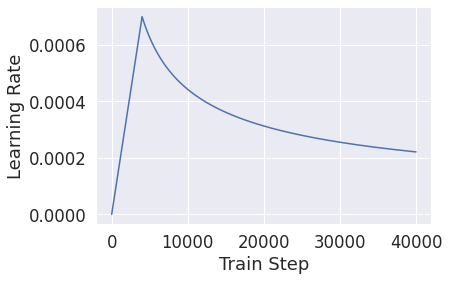

In [53]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

Target sequences are padded so we have to apply padding mask when calculating the loss.  

Use SparseCategoricalCrossentropy for labelling problems when labels are in integer form. Use CategoricalCrossentropy when the labels are in one-hot encoding format.

In [54]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [55]:
def loss_function(real, pred):
    # logcial_not: boolean value of NOT x, applied elementwise
    # math.equal: returns x == y elementwise
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [56]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

## Training and Checkpoint

In [57]:
DICT_WEIGHTS = {} # store the weights of the final layer of Transformer at each epoch.

In [58]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size(),
    target_vocab_size=tokenizers.en.get_vocab_size(), 
    pe_input=1000, 
    pe_target=1000,
    rate=dropout_rate)

In [59]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block (multihead attention) in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

  return enc_padding_mask, combined_mask, dec_padding_mask

Create checkpoint path and checkpoint manager.

In [60]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [61]:
EPOCHS = 100

The target is divided into `tar_inp` and `tar_real`. `tar_inp` is passed as an input to the decoder. `tar_real` is that same input shifted by 1: At each location in `tar_input`, `tar_real` contains the next token that should be predicted.

For example, sentence = "SOS A lion in the jungle is sleeping EOS"

`tar_inp` = "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next. During training this example uses teacher-forcing (like in the text generation tutorial). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step. For example, after "SOS" token is passed into transformer, pass the letter "A" in the next time step.

As the transformer predicts each word, self-attention allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peeking at the expected output the model uses a look-ahead mask.

In [62]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
    
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, True, enc_padding_mask, combined_mask, dec_padding_mask)
    loss = loss_function(tar_real, predictions)
  
  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))
    

Portugese is the input language and English is output language.

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):

    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print (f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  DICT_WEIGHTS[epoch] = transformer.final_layer.get_weights()

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 8.9564 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.6129 Accuracy 0.0253
Epoch 1 Batch 100 Loss 8.2885 Accuracy 0.0441
Epoch 1 Batch 150 Loss 8.0342 Accuracy 0.0525
Epoch 1 Batch 200 Loss 7.7720 Accuracy 0.0627
Epoch 1 Batch 250 Loss 7.5069 Accuracy 0.0738
Epoch 1 Batch 300 Loss 7.2786 Accuracy 0.0833
Epoch 1 Batch 350 Loss 7.0897 Accuracy 0.0909
Epoch 1 Batch 400 Loss 6.9405 Accuracy 0.0978
Epoch 1 Batch 450 Loss 6.8171 Accuracy 0.1053
Epoch 1 Batch 500 Loss 6.7054 Accuracy 0.1127
Epoch 1 Batch 550 Loss 6.6040 Accuracy 0.1203
Epoch 1 Batch 600 Loss 6.5145 Accuracy 0.1271
Epoch 1 Batch 650 Loss 6.4329 Accuracy 0.1331
Epoch 1 Batch 700 Loss 6.3539 Accuracy 0.1391
Epoch 1 Batch 750 Loss 6.2797 Accuracy 0.1445
Epoch 1 Batch 800 Loss 6.2136 Accuracy 0.1493
Epoch 1 Batch 850 Loss 6.1496 Accuracy 0.1541
Epoch 1 Batch 900 Loss 6.0918 Accuracy 0.1584
Epoch 1 Batch 950 Loss 6.0389 Accuracy 0.1622
Epoch 1 Batch 1000 Loss 5.9900 Accuracy 0.1656
Epoch 1 Batch 1050 Loss 5.9424 Accur

## Evaluate

In [ ]:
def evaluate(sentence, max_length=40):
  # inp sentence is portuguese, hence adding the start and end token
  sentence = tf.convert_to_tensor([sentence])
  sentence = tokenizers.pt.tokenize(sentence).to_tensor()

  encoder_input = sentence

  # as the target is english, the first word to the transformer should be the
  # english start token.
  start, end = tokenizers.en.tokenize([''])[0]
  output = tf.convert_to_tensor([start])
  output = tf.expand_dims(output, 0)

  for i in range(max_length):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)

    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)

    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.argmax(predictions, axis=-1)

    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

    # return the result if the predicted_id is equal to the end token
    if predicted_id == end:
      break

  # output.shape (1, tokens)
  text = tokenizers.en.detokenize(output)[0] # shape: ()

  tokens = tokenizers.en.lookup(output)[0]

  return text, tokens, attention_weights

In [ ]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [ ]:
sentence = "este é um problema que temos que resolver."
ground_truth = "this is a problem we have to solve ."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : so we have a problem .
Ground truth   : this is a problem we have to solve .


In [ ]:
sentence = "os meus vizinhos ouviram sobre esta ideia."
ground_truth = "and my neighboring homes heard about this idea ."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : i ' d like to talk about this .
Ground truth   : and my neighboring homes heard about this idea .


In [ ]:
sentence = "vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram."
ground_truth = "so i \'ll just share with you some stories very quickly of some magical things that have happened ."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' m going to share with you with you some of these things .
Ground truth   : so i 'll just share with you some stories very quickly of some magical things that have happened .


## Attention plots

In [ ]:
sentence = "este é o primeiro livro que eu fiz."
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : and this is the first picture of this .
Ground truth   : this is the first book i've ever done.


In [ ]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it. 
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))


  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [ ]:
head = 0
# shape: (batch=1, num_heads, seq_len_q, seq_len_k)
attention_heads = tf.squeeze(
  attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]
attention.shape

TensorShape([10, 11])

In [ ]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

In [ ]:
translated_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'and', b'this', b'is', b'the', b'first', b'picture',
       b'of', b'this', b'.', b'[END]'], dtype=object)>

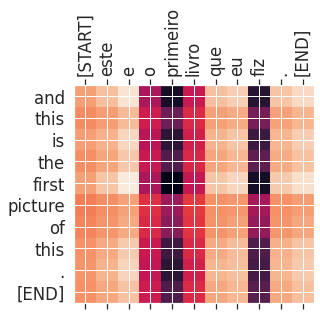

In [ ]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [ ]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]
  in_tokens

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel('Head {}'.format(h+1))

  plt.tight_layout()
  plt.show()

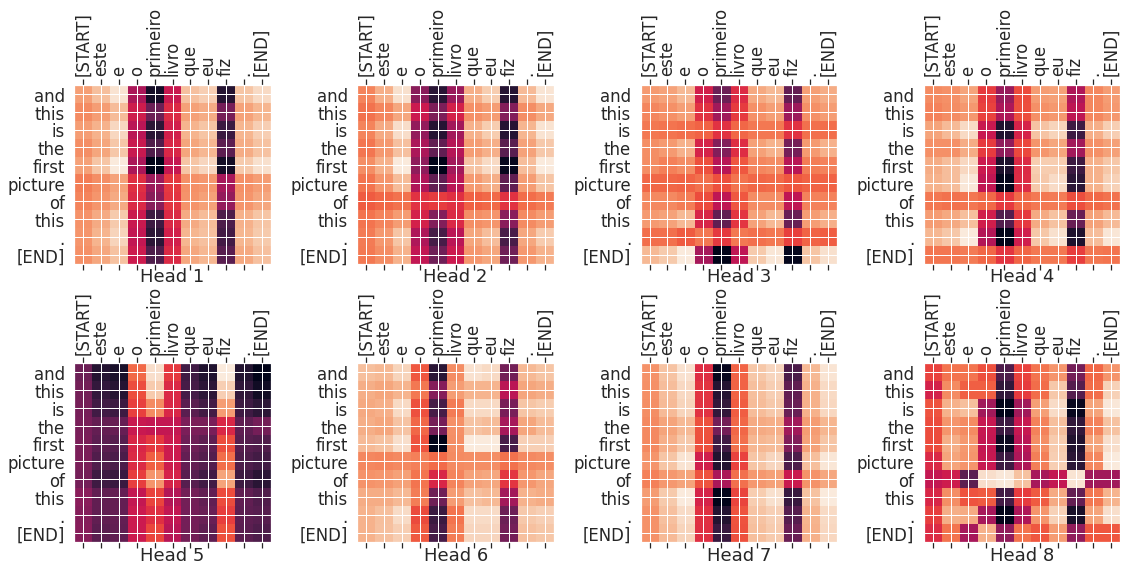

In [ ]:
plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

Input:         : Eu li sobre triceratops na enciclopédia.
Prediction     : i ' ve beenruping .
Ground truth   : I read about triceratops in the encyclopedia.


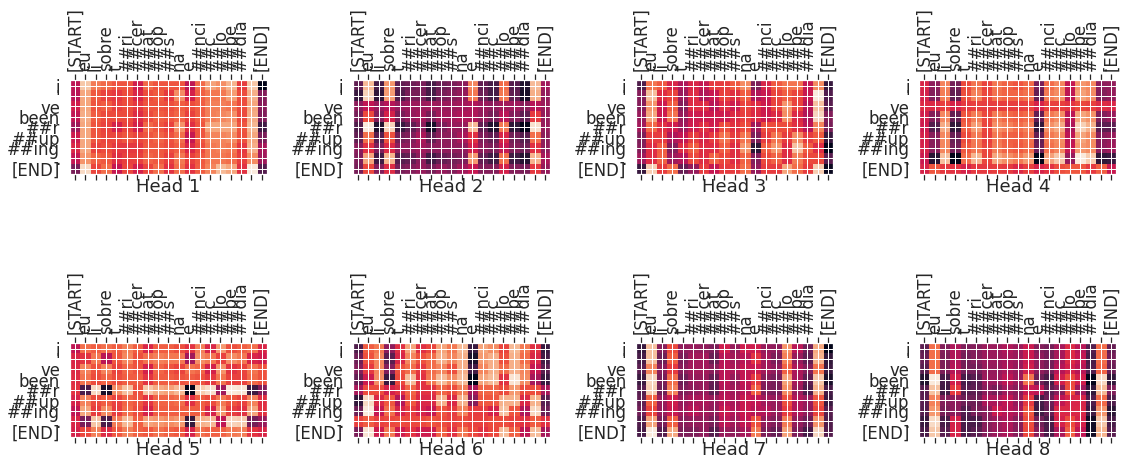

In [ ]:
sentence = "Eu li sobre triceratops na enciclopédia."
ground_truth = "I read about triceratops in the encyclopedia."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

In [ ]:
np.save("transformer_100epoch_weights.npy", DICT_WEIGHTS)

In [ ]:
!cp transformer_100epoch_weights.npy "drive/My Drive/DSA5204_mine/Transformer"

In [ ]:
print(ckpt_manager.checkpoints)

['./checkpoints/train/ckpt-16', './checkpoints/train/ckpt-17', './checkpoints/train/ckpt-18', './checkpoints/train/ckpt-19', './checkpoints/train/ckpt-20']


In [ ]:
pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
ls ./checkpoints/train

checkpoint                   ckpt-18.index
ckpt-16.data-00000-of-00001  ckpt-19.data-00000-of-00001
ckpt-16.index                ckpt-19.index
ckpt-17.data-00000-of-00001  ckpt-20.data-00000-of-00001
ckpt-17.index                ckpt-20.index
ckpt-18.data-00000-of-00001


In [ ]:
transformer.save_weights('transformer_100_epoch.h5')

In [ ]:
!cp transformer_100_epoch.h5 "drive/My Drive/"

To recall the weights, next time call `transformers.load_weights(path_to_load_weights)`